# Natural Language Processing Project

>Goals:
- Build a dataset of 100 Github repositories' readme text
- Explore the text of the readme's and find connections to programming language
- Build a classification ML model that predicts the programming language used in a repo based on readme content. 

In [1]:
import numpy as np
import pandas as pd
import json
import re
import warnings
warnings.filterwarnings("ignore")

from prepare import add_columns, split_repo_data
from explore import word_string, word_freq, word_counts, word_cloud
from explore import ngrams, plot_ngrams
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import text 

# acquire
from requests import get
from bs4 import BeautifulSoup
from time import sleep
import os

# prepare
import unicodedata
import re
import json
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

# explore
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# model
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

Prepare module loaded.


In [2]:
from model import bow_fe, tfidf_fe, tfidf_fe_test

---
## Acquire

In [3]:
# raw data
df = pd.read_json('repos.json')

In [4]:
# summary of data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 599 entries, 0 to 598
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   language  599 non-null    object
 1   repo      599 non-null    object
 2   content   599 non-null    object
dtypes: object(3)
memory usage: 18.7+ KB


In [5]:
df.head()

,language,repo,content
0,JavaScript,facebook/react,React · \nReact is a JavaScript library for...
1,JavaScript,d3/d3,D3: Data-Driven Documents\n\nD3 (or D3.js) is ...
2,JavaScript,vuejs/vue,\n\n\n\n\n\n\n\n\n\n\nSupporting Vue.js\nVue.j...
3,JavaScript,axios/axios,axios\n\n\n\n\n\n\n\n\nPromise based HTTP clie...
4,JavaScript,facebook/create-react-app,Create React App \n\nCreate React apps with n...


In [6]:
# how many of each language
df.language.value_counts()

JavaScript    300
Python        299
Name: language, dtype: int64

In [7]:
# number of unique repos
df.repo.nunique()

581

<div class="alert alert-block alert-info">
<b>Summary</b>:
    <li> Data acquired using the BeautifulSoup library </li>
<li> Used helper functions to get requests to the first 30 search pages of most starred repos for Javascript and Python. </li>
 <li>Used helper function to parse HTML to find certain elements that contained the <i>programming language</i>, <i>repo-sub url</i>, and the <i>readme content</i> for each repo among said pages and saved to a DataFrame. Stored as a json file locally for reproduction.</li>
</div>

---
## Prepare

In [8]:
# prepared data
df = pd.read_json('repos_clean.json').reset_index().drop(columns='index')

In [9]:
# adds list of words column and length of cleaned doc
df = add_columns(df)

In [10]:
# prepped data summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581 entries, 0 to 580
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   language    581 non-null    object
 1   repo        581 non-null    object
 2   content     581 non-null    object
 3   stemmed     581 non-null    object
 4   lemmatized  581 non-null    object
 5   clean       581 non-null    object
 6   words       581 non-null    object
 7   doc_length  581 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 36.4+ KB


In [11]:
# split the data
train, validate, test = split_repo_data(df)

In [12]:
print(train.language.value_counts(), '\n')
print(validate.language.value_counts(), '\n')
print(test.language.value_counts())
train.head(3)

JavaScript    180
Python        168
Name: language, dtype: int64 

JavaScript    60
Python        56
Name: language, dtype: int64 

JavaScript    60
Python        57
Name: language, dtype: int64


,language,clean,words,doc_length
277,Python,welcome streamlit fastest way build share data...,"[welcome, streamlit, fastest, way, build, shar...",202
97,JavaScript,translation espaol deutsch portugus trke add f...,"[translation, espaol, deutsch, portugus, trke,...",633
501,Python,plotlypy latest release user forum pypi downlo...,"[plotlypy, latest, release, user, forum, pypi,...",399


<div class="alert alert-block alert-info">
<b>Summary</b>:
    <li>Readme content is normalized, tokenized, stemmed, lemmatized, and stopwords are removed to produce "clean" content.</li>
    <li>Duplicate repos are removed and 2 columns are created</li>
    <li>The data is split into train, validate, and, test; stratifying on the programming language.</li>
</div>

---
## Explore

> **What's the proportion of each language in our data?**

In [13]:
# total counts and proportions of each language 
labels = pd.concat([train.language.value_counts(), 
                    train.language.value_counts(normalize=True)], axis=1) 
labels.columns = ['n', 'percent']
labels

,n,percent
JavaScript,180,0.517241
Python,168,0.482759


> **What are the most common words in READMEs?**

In [14]:
# used helper functions from explore.py
js_words, py_words, all_words = word_string(train)
js_freq, py_freq, all_freq = word_freq(js_words, py_words, all_words)
word_counts = word_counts(js_freq, py_freq)

In [15]:
# more refined list that frequents one language as opposed to the other
print('20 Most Common Words')
refined_wordcounts = word_counts[(word_counts.prop_js <= .40) | (word_counts.prop_js >= .60)]
refined_wordcounts.sort_values(by=['all', 'prop_js'], ascending=False).head(20)

20 Most Common Words


,js,py,all,prop_js
python,32,1374,1406,0.022760
function,1032,373,1405,0.734520
data,384,830,1214,0.316310
react,1205,6,1211,0.995045
native,1051,27,1078,0.974954
default,670,363,1033,0.648596
library,330,606,936,0.352564
return,660,254,914,0.722101
object,638,265,903,0.706534
new,588,305,893,0.658455


> **Does the length of the README vary by programming language?**

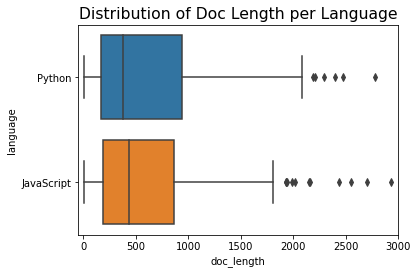

In [16]:
sns.boxplot(y=train.language, x=train.doc_length, orient="h")
plt.xlim(-50, 3000)
plt.rc('font', size=13)
plt.title('Distribution of Doc Length per Language')
plt.tight_layout()

In [17]:
# descriptive statistics for each languages' document length
train.groupby('language').doc_length.describe()

,count,mean,std,min,25%,50%,75%,max
language,,,,,,,,
JavaScript,180.0,935.266667,1530.272370,11.0,187.75,436.5,860.5,10505.0
Python,168.0,915.589286,1570.565409,3.0,171.25,382.0,940.0,10538.0


> **Do different programming languages use a different number of unique words?**

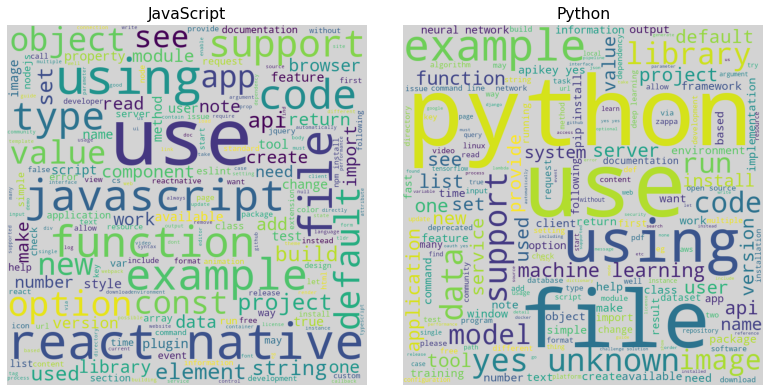

In [18]:
word_cloud(js_words, py_words)

>**What are the highest frequencies of word combinations?** *ie. ngrams*

In [19]:
# bigrams and trigrams for each language
js_bigrams, py_bigrams = ngrams(js_words, py_words, 2)
js_trigrams, py_trigrams = ngrams(js_words, py_words, 3)

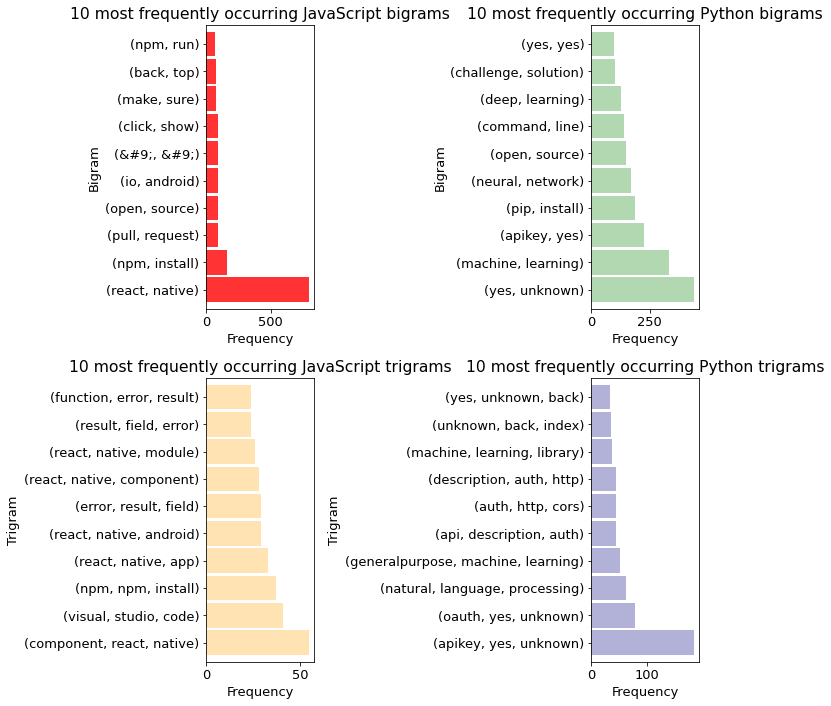

In [20]:
plot_ngrams(js_bigrams, py_bigrams, js_trigrams, py_trigrams)

# Custom Word Cloud

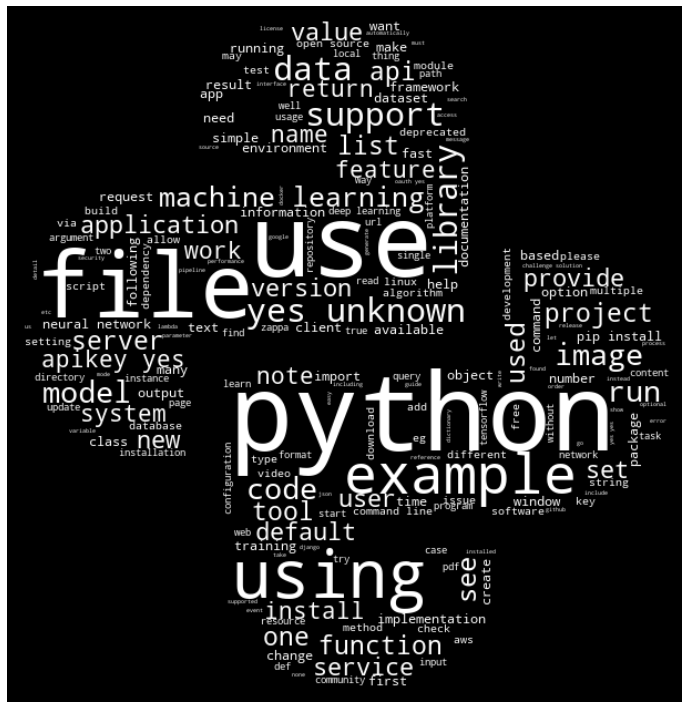

<Figure size 432x288 with 0 Axes>

In [30]:
from PIL import Image

py_mask = np.array(Image.open('py_icon_crop.png'))


wc = WordCloud(background_color='black', mask=py_mask, mode='RGB', color_func = lambda *args, **kwargs: "white", width=1000, max_words=200, height=1000, random_state=1)
wc.generate(py_words)


plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()
plt.savefig('python_complete.png')

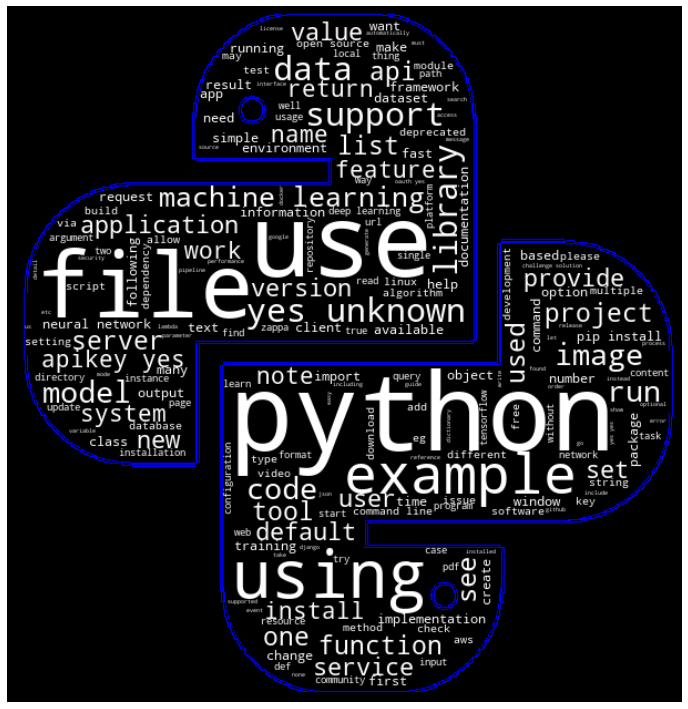

In [24]:
# Adding an outline of the mask:

py_mask = np.array(Image.open('py_icon_crop.png'))

wc = WordCloud(background_color='black', mask=py_mask, mode='RGB', color_func = lambda *args, **kwargs: "white", width=1000, max_words=200, height=1000, random_state=1,
              contour_width = .1, contour_color = 'blue')
wc.generate(py_words)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

## Now JavaScript

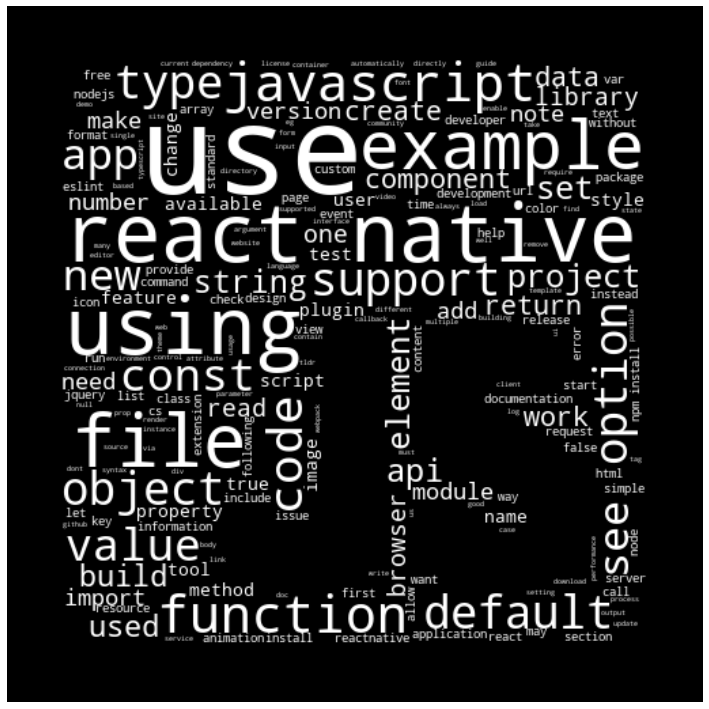

In [29]:
js_mask = np.array(Image.open('javascript_solid.png'))


wc = WordCloud(background_color='black', mask=js_mask, mode='RGB', color_func = lambda *args, **kwargs: "white", width=1000, max_words=200, height=1000, random_state=1)
wc.generate(js_words)


plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

<div class="alert alert-block alert-info">
<b>Summary</b>:
    <li>The distribution of JavaScript and Python data is nearly 1:1</li>
    <li>Words counts with a distribution of between 40-60% are likely to be useless. Words on both ends of those tails will be more significant in classifying language in the modeling section </li>
    <li>Word combinations may be more useful in classification since the combinations are more unique than individual words. </li>
</div>

## Hypothesis Testing:

##### Alpha is set at .05

- Is the average document length for Python READMEs longer or shorter than the overall average document length?
    - We will use a two-tailed t-test for this question.
    
-------

#### Hypothesis 1:

- $H_0$: The average `doc_length` of the python readmes are not statistically different from the overall population average `doc_length`
- $H_a$: The average `doc_length` of the python readmes **are** statistically different from the overall population average `doc_length`

In [ ]:
# Creating a separate df for hypothesis testing:

train_explore = df.copy()

In [ ]:
import scipy.stats as stats

# Setting the alpha level:
alpha = .05

# Python sample:
py_doc = train_explore[train_explore.language == 'Python'].doc_length
js_doc = train_explore[train_explore.language == 'JavaScript'].doc_length

# Finding the means:
py_doc_avg = train_explore[train_explore.language == 'Python'].doc_length.mean()
js_doc_avg = train_explore[train_explore.language == 'JavaScript'].doc_length.mean()
print(py_doc_avg, js_doc_avg)

In [ ]:
# Population Mean:
pop_mean = train_explore.doc_length.mean()
print(pop_mean)

#### Python T-Test:

In [ ]:

t, p = stats.ttest_1samp(py_doc, pop_mean)
print(f"Our t-value is {t}, and our p-value is {p}")

if p < alpha:
    print("Our p-value is less than our alpha, thus the null hypothesis is rejected.")
else:
    print("Our p-value is greater than our alpha, thus we fail to reject the null hypothesis ")

#### Hypothesis Test Result:

- Null hypothesis was not rejected, meaning there is no statistically significant difference in the mean between the python average README doc lengths and the overall README average doc length.

#### Hypothesis 2:

- $H_0$: The average `doc_length` of the JavaScript readmes are not statistically different from the overall population average `doc_length`
- $H_a$: The average `doc_length` of the JavaScript readmes **are** statistically different from the overall population average `doc_length`

In [ ]:
# JavaScript t-test:

t_js, p_js = stats.ttest_1samp(js_doc, pop_mean)

print(f"Our t-value is {t_js}, and our p-value is {p_js}")

if p_js < alpha:
    print("Our p-value is less than our alpha, thus the null hypothesis is rejected.")
else:
    print("Our p-value is greater than our alpha, thus we fail to reject the null hypothesis ")

#### Hypothesis Test Result:

- Null hypothesis was not rejected, meaning there is no statistically significant difference in the mean between the JavaScript average README doc lengths and the overall README average doc length.

#### Hypothesis 3:

Using a Chi2 test

- $H_0$: The average `doc_length` of the JavaScript readmes are not statistically different from the python  average `doc_length`
- $H_a$: The average `doc_length` of the JavaScript readmes **are** statistically different from the python  average `doc_length`

In [ ]:
python_only = df[df.language == "Python"]



In [ ]:
chi2, p, degf, expected = stats.chi2_contingency(observed)

print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

---
## Model

#### Establishing a Baseline

In [ ]:
train.language.value_counts()

In [ ]:
baseline_count = pd.concat([train.language.value_counts(), train.language.value_counts(normalize = True)], axis = 1)
baseline_count.columns = ['count', 'percent']
baseline_count

In [ ]:
# Taking the most common result (JavaScript) and making that the baseline prediction.
#This is the % accuracy our model would be at if guessing a Readme was JavaScript every single time:
baseline = round(len(train[train.language == 'JavaScript']) / len(train), 2)

print(f"The baseline model's accuracy is: {baseline:.0%}")

It appears that JavaScript is the most often occuring result of the two languages represented, thus we will take as our baseline assuming that all README's are in JavaScript, which would mean our baseline model is accurately approximately 52% of the time.

### Feature Extraction

In [ ]:
# Using Bag of Words
X_train_bow, X_validate_bow, X_test_bow = bow_fe(train, validate, test)

# Using Term Frequency - Inverse Document Frequency
X_train_tfidf, X_validate_tfidf, X_test_tfidf = tfidf_fe(train, validate, test)

In [ ]:
# set target variable
y_train = train['language']
y_validate = validate['language']
y_test = test['language']

<div class="alert alert-block alert-info">
<b>Summary</b>:
    <li>Using <b>Bag of Words</b> and <b>TF-IDF</b> to assign a numerical value to each word for modeling</li>
    <li>Set X and y variables for computing</li>
    <li>Used helper functions from <i>model.py</i> for cleaner documentation</li>
</div>

---
## Evaluate

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

## Test

- **Testing two models:**
    1. A Logistic Regression Model using two feature selections; bag of words and TF-IDF
    2. A Decition Tree Model using features selected by TD-IDF

#### Model 1: Logistic Regression using BOW

In [ ]:
# Fit the LogisticRegression on BOW features
lm_bow = LogisticRegression().fit(X_train_bow, y_train)

# Predict the labels
y_pred_bow = lm_bow.predict(X_train_bow)
train['pred_bow'] = y_pred_bow

In [ ]:
# Confusion Matrix Train
pd.crosstab(train.language, train.pred_bow)

In [ ]:
# Compute the performance metrics
print('TRAIN DATA\n', classification_report(train.language, train.pred_bow))

#### Model 2: Logistic Regression using TF-IDF

In [ ]:
# Fit the LogisticRegression on TFIDF features
lm_tfidf = LogisticRegression().fit(X_train_tfidf, y_train)

# Predict the labels
y_pred_tf = lm_tfidf.predict(X_train_tfidf)
train['pred_tf'] = y_pred_tf

In [ ]:
lm_tfidf.predict

In [ ]:
# Confusion Matrix Train
pd.crosstab(train.language, train.pred_tf)

In [ ]:
# Compute the performance metrics 
print('TRAIN DATA\n', classification_report(train.language, train.pred_tf))

#### Model 3: Decision Tree using TF-IDF

In [ ]:
add_stopwords = ['file', 'import', 'use', 'return', 'also', 'code', 'using', 'see', 'install', 'default', '10', '100', '1000', '11', '12', '15', '20', '27', '30', '35', '36', '40', 'able', 'access', 'account', 'action', 'active', 'actually', 'add', 'avoid', 'awesome']
my_stop_words = text.ENGLISH_STOP_WORDS.union(add_stopwords)

In [ ]:
# Creating a Decision Tree Model:


tfidf_tree = TfidfVectorizer(stop_words=my_stop_words, min_df=8, 
                                     ngram_range=(1,2), 
                                     binary=True)

tfidf_sparse_matrix_tree = tfidf_tree.fit_transform(train.clean)
X_dt = tfidf_sparse_matrix_tree
tree = DecisionTreeClassifier(max_depth=3, random_state=123)
tree_fit = tree.fit(X_dt, train.language)
train['pred_tfidf_tree'] = tree_fit.predict(X_dt)

#### Decision Tree Model Results:

In [ ]:
# print('Decision Tree TF-IDF Accuracy:',accuracy_score(train.language, train.predicted_tfidf).round(2)*100,'%','\n')
print(classification_report(train.language, train.pred_tfidf_tree))
pd.crosstab(train.language, train.pred_tfidf_tree)

#### Takeaway: 

- Decision Tree model using TD-IDF did not yield a higher accuracy result than the Logistic Regression model using Bag of Words or TD_IDF. However, since the Logistic Regression model appears to have been overfitting, we opted to continue using DT into the Validate phase. In future we would like to experiment with further adjustments to the hyperparameters to see if this model would yield better results.

### Validate

#### Validating Logistic Regression on the TF-IDF Logsistic Regression

In [ ]:
# Predict for validate
y_pred_bow_v = lm_bow.predict(X_validate_bow)

# Compute the performance metrics for bow features. 
print('VALIDATE DATA\n', classification_report(validate.language, y_pred_bow_v))

In [ ]:
# Predict for validate
y_pred_tf_v = lm_tfidf.predict(X_validate_tfidf)

In [ ]:
# Compute the performance metrics for the LogR model with tf-idf
print('VALIDATE DATA\n', classification_report(validate.language, y_pred_tf_v))

In [ ]:
# Checking the DT model on validate:
tree_validate = tree


<div class="alert alert-block alert-info">
<b>Summary</b>:
    <li>TF-IDF Logistic Regression Model performed best</li>
    <li>Going to move forward with this model for testing on unseen data</li>
</div>

#### Test

In [ ]:
# Predict for test
y_pred_tf_t = lm_tfidf.predict(X_test_tfidf)

# Compute the performance metrics 
print('TEST DATA\n', classification_report(test.language, y_pred_tf_t))

In [ ]:
# Confusion Matrix Train
pd.crosstab(test.language, y_pred_tf_t)

### Results:

- The results of testing and validating our 

In [ ]:
confusion_matrix(y_train, y_pred_bow)

In [ ]:
con_mat = confusion_matrix(y_train, y_pred_bow)
con_mat

In [ ]:
tn = con_mat[0][0]
fp = con_mat[0][1]
fn = con_mat[1][0]
tp = con_mat[1][1]

accuracy = (tp + tn) / (tp + tn + fp + fn)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
tnrate = tn / (tn + fp)

In [ ]:
accuracy, recall, precision, tnrate

### 2nd Test Dataset

- We used a final unseen set of data to test our best model against to determine if the model was overfitting or if we could assign the high accuracy score to another cause.
- Using our top performing Logistic Regression Model using features derived through TF-IDF, 

In [ ]:
# read in new repo data (unseen) to test model further
test2 = pd.read_json('test_repos_clean.json')

In [ ]:
# 200 new data points
test2.shape

In [ ]:
# tfidf 
X_test2 = tfidf_fe_test(train, test2)

# Predict for test 2
y_pred_tf_t2 = lm_tfidf.predict(X_test2)

In [ ]:
# Compute the performance metrics 
print('TEST 2 DATA\n', classification_report(test2.language, y_pred_tf_t2))

In [ ]:
# Confusion Matrix Train
pd.crosstab(test2.language, y_pred_tf_t2)

In [ ]:
pd.DataFrame(columns=['accuracy', 'precision', 
                      'recall', 'f1-score'], 
             index=['baseline', 'train', 
                    'validate', 'test_1', 
                    'test_2'], 
             data=[.52, .99, .93, .89, .92],
                  [0, .99, .96, .9, .9], 
                  [], [])

---
## Conclusions

- Since we limited the languages of the repositories we scraped to JavaScript and Python, we ended up with a binary choice for our classification models.
- We have run two different classification algorithms here: 
    1. Logistic Regression
    2. Decision Tree
  
  The results of the tests show that the model with the highest consistent accuracy is the Logistic Regression model using TF-IDF to vectorize the words (into features) for the model.
- We suspect that the high degree of accuracy is cause both by some overfitting (which was reduced by adjusting the hyperparameters of the models) as well as the fact that we are only giving the classification model two languages to choose from. As shown in some of the exploration stage, we can see that there is enough distinctness in the words typically used in the Python and JavaScript repositories that allowed the models to determine the languages of the repository with relative ease. 
    - However, if additional languages had been added, for example adding Java or R into the mix, we expect that the overall accuracy and recall of the models would have gone down. We hypothesize this would've been due to the similarities of the purpose of those languages (not the syntax of those languages), thus the natural language surrounding those languages would have been harder for the model to decipher.
    - At the same

#### Next Steps:
- As we continue to expand on the project, we would like to introduce additional languages into our repository scraping. That is the single biggest step we can make to improve the robustness of the model.
- We would have done more exploration related to which language introduced the most inaccuracy; ie, was it more difficult for the model to decipher the Python repositories accurately, or was it the JavaScript repositories? This question would have extended to the additional languages under the expanded scraping mentioned above.